# 종합실습2 : 금융 사기거래 탐지



## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

### (2) 데이터셋 불러오기

In [2]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/creditcard_simple.csv"
data = pd.read_csv(path)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,amount,fraud
0,0.733,-0.544,-0.601,0.020,0.181,0.172,-1.768,-0.083,-0.323,0.110,-0.019,-0.457,-0.088,0.167,0.270,-0.513,-0.006,0.044,199.45,0
1,1.942,-0.056,1.319,1.197,0.367,0.265,0.006,0.310,-0.522,-0.223,-0.268,-0.595,0.345,-1.040,-0.432,0.280,-0.018,-0.057,1.98,0
2,-0.223,1.182,0.166,-1.328,0.151,-0.101,-0.489,0.476,0.034,-0.174,0.404,1.288,-0.076,0.071,-0.787,-0.218,0.382,0.259,0.89,0
3,0.672,-1.261,-0.602,-0.866,-0.335,0.875,0.786,0.012,1.338,0.655,0.201,0.078,-0.527,0.133,0.745,0.041,-0.074,0.049,340.31,0
4,-3.368,0.099,0.458,-1.572,0.672,-3.188,1.019,-0.590,1.930,0.265,0.861,1.249,1.851,-0.117,1.220,0.000,1.036,0.004,320.01,1


In [3]:
print(data['fraud'].value_counts())
print('='* 100)
print(data['fraud'].value_counts()/data.shape[0])

0    19508
1      492
Name: fraud, dtype: int64
0    0.9754
1    0.0246
Name: fraud, dtype: float64


## 2.데이터 준비

* 데이터 분할
    * x, y 나누기
    * train, val 나누기 : validation set을 6000건으로

In [4]:
target = 'fraud'
x = data.drop(target, axis=1)
y = data[target]

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=6000, random_state=20)

In [6]:
x_train.shape, y_train.shape

((14000, 19), (14000,))

In [7]:
x_val

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,amount
9812,-0.308,1.004,0.311,-0.382,-0.015,-0.759,0.753,1.590,0.564,0.125,-0.132,-0.329,0.047,0.057,-0.657,0.193,0.142,0.158,1.98
7615,0.104,0.860,-0.291,1.674,-1.239,-0.263,-0.471,0.767,0.608,-0.272,1.575,-0.158,-0.199,-0.758,0.728,0.537,0.277,0.226,22.74
14799,0.585,-2.524,-2.102,-0.115,0.062,-1.869,-0.842,0.488,-0.511,0.426,-0.035,-0.777,-0.135,0.164,-0.198,-0.451,-0.032,0.089,435.70
16457,-1.473,-0.317,1.548,-0.706,0.247,-0.544,0.380,-1.508,-0.679,0.161,0.176,0.307,0.038,0.234,0.121,-0.527,0.088,0.141,15.54
6563,1.924,-0.349,-0.100,-0.350,-0.096,0.462,0.546,-0.459,0.313,-0.063,0.020,0.101,0.102,-0.456,-0.170,0.230,-0.050,-0.059,54.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,2.042,0.396,1.100,-0.732,-0.235,0.348,-1.486,-0.150,-0.255,-0.274,-0.077,-0.097,-0.040,0.110,0.494,-0.491,-0.012,-0.028,17.37
15290,1.942,0.536,1.197,0.551,0.059,-1.230,-1.150,-1.837,-0.838,-0.318,-0.013,-0.066,0.066,0.086,0.232,0.008,-0.076,-0.071,11.24
1714,-0.092,0.537,0.801,-0.441,-0.188,-0.074,0.701,-0.372,0.284,0.241,-0.264,-0.734,0.158,-1.008,-0.294,0.198,0.215,0.096,89.99
12521,1.180,0.447,-0.542,-1.166,-0.285,-0.195,1.292,0.854,-0.501,-0.059,-0.176,-0.465,0.147,0.905,0.341,-0.669,0.033,0.039,9.99


## 3.모델링1
* Isolation Forest 모델을 생성합니다.
    * Contamination 값을 조절하면서 모델을 최적화 합시다.
    * 성능은 사기거래에 대한 f1 스코어 입니다.

In [8]:
cont = np.linspace(0.001, 0.3, 150)
f1_list=[]
for c in tqdm(cont):
    model = IsolationForest(contamination=c, random_state=20)
    model.fit(x_train)
    pred = model.predict(x_val)
    pred = np.where(pred == 1, 0, 1)
    
    f1_list.append(f1_score(y_val, pred))

100%|██████████| 150/150 [01:08<00:00,  2.20it/s]


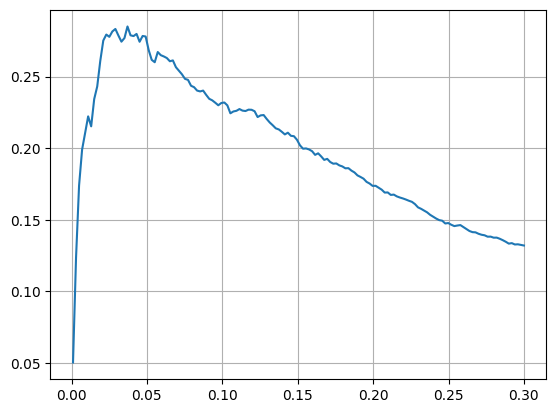

In [9]:
plt.plot(cont, f1_list)
plt.grid()
plt.show()

In [10]:
c = cont[np.argmax(f1_list)]

In [11]:
model = IsolationForest(contamination=c, random_state=20)
model.fit(x_train)
pred = model.predict(x_val)
pred = np.where(pred == 1, 0, 1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[5651  196]
 [  95   58]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5847
           1       0.23      0.38      0.29       153

    accuracy                           0.95      6000
   macro avg       0.61      0.67      0.63      6000
weighted avg       0.96      0.95      0.96      6000



## 4.모델링2
* Isolation Forest 모델을 생성합니다.
    * 모델링1에서 찾은 contamination 값을 고정시켜놓고
    * n_estimators 값을 조절해 봅시다.
        * 범위는 여러분이 알아서 지정하세요.

In [12]:
esti = range(100, 3001, 100)
f1_list=[]
for t in tqdm(esti):
    model = IsolationForest(contamination=c, n_estimators=t, random_state=20)
    model.fit(x_train)
    pred = model.predict(x_val)
    pred = np.where(pred == 1, 0, 1)
    
    f1_list.append(f1_score(y_val, pred))

100%|██████████| 30/30 [03:23<00:00,  6.78s/it]


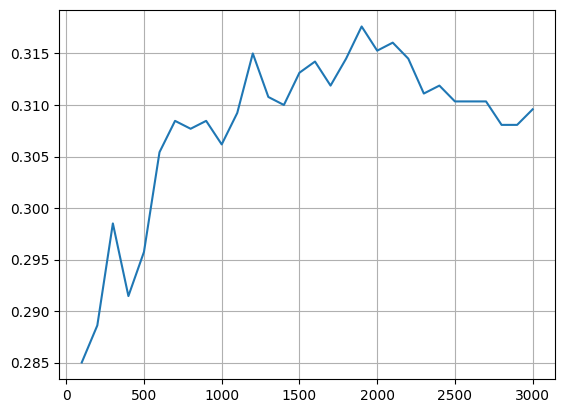

In [13]:
plt.plot(esti, f1_list)
plt.grid()
plt.show()

In [14]:
t = esti[np.argmax(f1_list)]

In [15]:
model = IsolationForest(contamination=c, n_estimators=t, random_state=20)
model.fit(x_train)
pred = model.predict(x_val)
pred = np.where(pred == 1, 0, 1)
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[5661  186]
 [  89   64]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5847
           1       0.26      0.42      0.32       153

    accuracy                           0.95      6000
   macro avg       0.62      0.69      0.65      6000
weighted avg       0.97      0.95      0.96      6000



## 5.[추가]모델링3
* One Class SVM 모델을 생성합니다.
    * nu, gamma를 조절하면서 최고의 성능(f1)을 얻는 모델을 생성해 봅시다.
    * isolation forest 모델과 비교해 봅시다.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM

In [17]:
scaler = MinMaxScaler()

x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

In [18]:
x_train0 = x_train_s[y_train == 0]

In [19]:
model = OneClassSVM()
model.fit(x_train0)
pred = model.predict(x_val_s)
pred = np.where(pred == 1, 0, 1)

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[2899 2948]
 [  20  133]]
              precision    recall  f1-score   support

           0       0.99      0.50      0.66      5847
           1       0.04      0.87      0.08       153

    accuracy                           0.51      6000
   macro avg       0.52      0.68      0.37      6000
weighted avg       0.97      0.51      0.65      6000

